# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Выгрузим нужные библиотеки и датасеты. Ознакомимся с общей информацией.

*Описание данных*

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [44]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
for _ in df0,df1,df2:
    print(_.info())
    print("*" * 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2   

In [4]:
for _ in df0,df1,df2:
    print(_.describe())
    print("*" * 70)

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
**********************************************************************
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%  

Средний объём в скважине из второго региона меньше чем в первом и третьем.

In [5]:
for _ in df0,df1,df2:
    print("Количество дубликатов в таблице:", _.duplicated().sum())
    print("*" * 10)

Количество дубликатов в таблице: 0
**********
Количество дубликатов в таблице: 0
**********
Количество дубликатов в таблице: 0
**********


In [6]:
for _ in df0,df1,df2:
    _.drop('id', axis=1, inplace=True)

In [7]:
df0.name = 'Регион 1'
df1.name = 'Регион 2'
df2.name = 'Регион 3'

Столбец id категориальный, все значения уникальны, нет смысла его кодировать, удалим его из датафреймов.

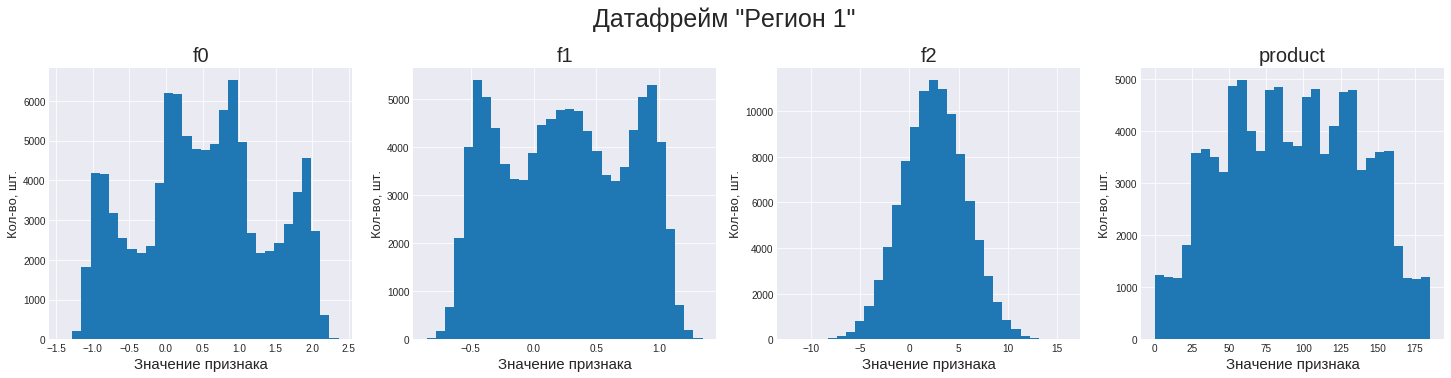

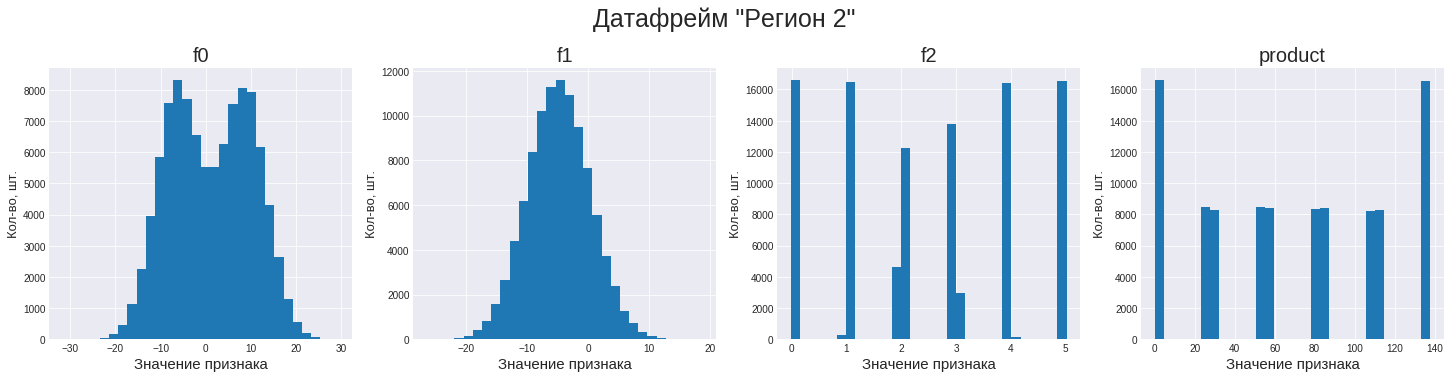

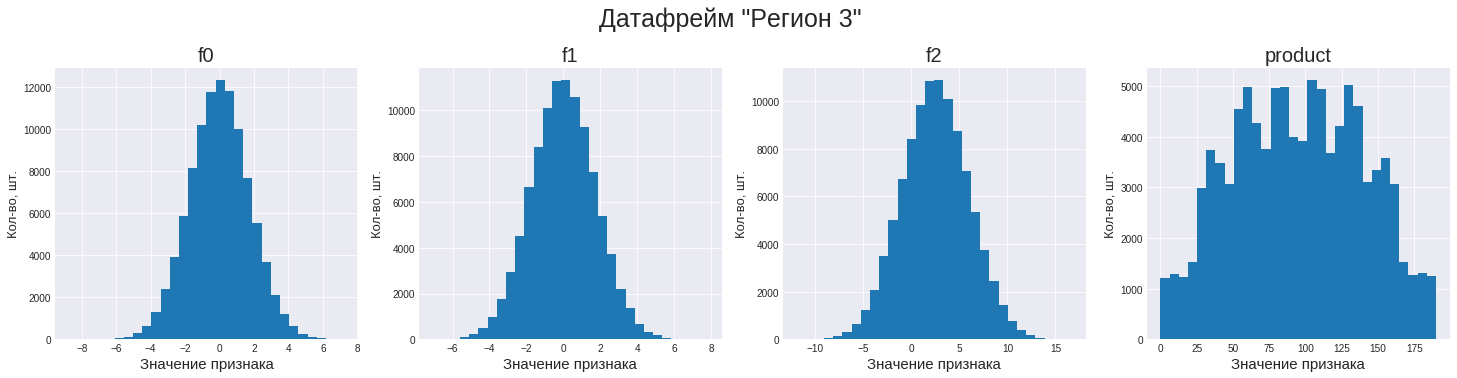

In [8]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

for _ in df0,df1,df2:
    fig = plt.figure(figsize=(25, 5))
    ttl = fig.suptitle('Датафрейм "{}"'.format(_.name), fontsize=25)
    ttl.set_position([.5, 1.05])
    
    rows = 1
    cols = 4
    counter = 1
    for column in _.columns:
        ax = plt.subplot(rows, cols, counter)
        plt.xlabel('Значение признака', fontsize=15)
        plt.ylabel('Кол-во, шт.', fontsize=13)
        ax.set_title(column, fontsize=20)
        _[column].hist(bins=30)
        counter += 1
    print('\n')
    plt.show()

На графиках также можем наблюдать, что по объёму запасов в скважине второй регион заметно отличается от первого и третьего: медиана у второго региона ощутимо ниже.

In [9]:
df1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

In [10]:
df1[df1['product'] == 0].count()

f0         8235
f1         8235
f2         8235
product    8235
dtype: int64

In [11]:
df0[df0['product'] == 0].count()

f0         1
f1         1
f2         1
product    1
dtype: int64

In [12]:
df2[df2['product'] == 0].count()

f0         1
f1         1
f2         1
product    1
dtype: int64

Очень необычно, что столбец с вещественными числами(объём запасов) во втором регионе имеет всего лишь 12 уникальных значений. Я бы обязательно уточнил у ответственного сотрудника, но сейчас удовлетворимся идеей, что данные составлены искуственно. 

Также оказалось около 8,2% нулевых значений в столбце с запасом нефти второго региона.

In [13]:
title=0
for _ in df0,df1,df2:
    print(f"Матрица корреляции DataFrame №{title}:")
    print( _.corr())
    print("*" * 50)
    title+=1

Матрица корреляции DataFrame №0:
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
**************************************************
Матрица корреляции DataFrame №1:
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
**************************************************
Матрица корреляции DataFrame №2:
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000
**************************************************


Обнаружили сильную прямую завимсимость между запасами и признаком f2 во втором регионе, остальные корреляции незначительны либо отсутствуют вовсе.


**Вывод** В столбце запасов второго утеряно/не заполнено 8,2% значений, либо исследования не проводились, либо скважины окзались реально пустыми.

По гистограмммам можем видеть, что первый и третий регион имеют несколько пиковых значений, скорее всего это говорит о том, что близкие друг к другу скважины, которые расположены кластерно, имеют примерно одинаковые запасы по прогнозу.

## Обучение и проверка модели

1.Разобьём данные на обучающую и валидационную выборки в соотношении 75:25

In [14]:
def linear_prediction(data):
    features = data.drop(['product'], axis = 1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=42)
    
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    return pd.Series(model.predict(features_valid)), target_valid

2. Обучим модель и сделаем предсказания на валидационной выборке. Сохраним предсказания и правильные ответы на валидационной выборке.

In [15]:
predict_df0, target_df0 = linear_prediction(df0)
predict_df1, target_df1 = linear_prediction(df1)
predict_df2, target_df2 = linear_prediction(df2)

3. Напечатаем на экране средний запас предсказанного сырья и RMSE модели. Проанилизируем результат.

In [16]:
def mean_product_and_rmse(predictions, target):
    mse = mean_squared_error(target, predictions)
    print('Средний запас сырья, тыс. баррелей:', predictions.mean())
    print('RMSE:', mse ** 0.5)

In [17]:
print('Регион 1')
mean_product_and_rmse(predict_df0, target_df0)

Регион 1
Средний запас сырья, тыс. баррелей: 92.39879990657768
RMSE: 37.75660035026169


In [18]:
print('Регион 2')
mean_product_and_rmse(predict_df1, target_df1)

Регион 2
Средний запас сырья, тыс. баррелей: 68.71287803913764
RMSE: 0.8902801001028834


In [19]:
print('Регион 3')
mean_product_and_rmse(predict_df2, target_df2)

Регион 3
Средний запас сырья, тыс. баррелей: 94.77102387765939
RMSE: 40.145872311342174


Получили очень низкий показатель отклонения во втором регионе. Это говорит о том, что мы с большой долей вероятности можем найти месторождение близкое к среднему по региону. С другой стороны, у нас есть два региона, в которых среднее значение запаса скважины значительно выше, но из-за большого RMSE высока вероятность, что мы отклонимся от среднего в пределах стандартного отклонения, таким образом, возможно, запас скважины будет меньше, чем предсказанный для второго региона. 

## Подготовка к расчёту прибыли

1. Ключевые значения для расчётов сохраним в отдельных переменных.
- При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [30]:
BOOTSTRAP_SAMPLES = 1000
BUDGET = 10_000_000_000
EXPLORE_WELLS = 500
BEST_WELLS = 200
BARRELS_PRICE_PER_1K = 450_000
RISK_LOSS = 0.025

2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.


In [21]:
point_of_make_out = BUDGET / BARRELS_PRICE_PER_1K
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(point_of_make_out))
print("Средний объем нефти в скважине для безубыточного функционирования:", np.ceil(point_of_make_out/200))

Точка безубыточности: 22222 тыс. баррелей
Средний объем нефти в скважине для безубыточного функционирования: 112.0


In [22]:
title=0
for _ in df0,df1,df2:
    print(f"Средний фактический объём добычи в регионе №{title}:", _['product'].mean())
    print("*" * 70)
    title+=1

Средний фактический объём добычи в регионе №0: 92.50000000000001
**********************************************************************
Средний фактический объём добычи в регионе №1: 68.82500000000002
**********************************************************************
Средний фактический объём добычи в регионе №2: 95.00000000000004
**********************************************************************


Вывод: добыча будет безубыточной для скважин , в которых запас не менее 112 тыс. баррелей. Средний запас сырья по каждому из регионов ниже необходимого для безубыточности.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

1. Выберем скважины с максимальными значениями предсказаний
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитаем прибыль для полученного объёма сырья.

In [50]:
def max_predict(predictions, target):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:BEST_WELLS].index
    selected = target[predictions_s]
    revenue = selected.sum() * BARRELS_PRICE_PER_1K - BUDGET
    
    return revenue

In [37]:
print(f'Прибыль для полученного объёма сырья для Региона 1: {round(max_predict(predict_df0, target_df0) / 1_000_000_000, 4)} млрд.руб.')

Прибыль для полученного объёма сырья для Региона 1: 3.3591 млрд.руб.


In [38]:
print(f'Прибыль для полученного объёма сырья для Региона 2: {round(max_predict(predict_df1, target_df1) / 1_000_000_000, 4)} млрд.руб.')

Прибыль для полученного объёма сырья для Региона 2: 2.4151 млрд.руб.


In [39]:
print(f'Прибыль для полученного объёма сырья для Региона 3: {round(max_predict(predict_df2, target_df2) / 1_000_000_000, 4)} млрд.руб.')

Прибыль для полученного объёма сырья для Региона 3: 2.5986 млрд.руб.


**Посчитаем риски и прибыль для каждого региона. Найдем распределение прибыли с помощью техники Bootstrap.**

1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [51]:
def bootstrap(target, probabilities):
    state = np.random.RandomState(42)
    values = []
    
    for i in range(BOOTSTRAP_SAMPLES):
        target_subsample = target.sample(n=EXPLORE_WELLS, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(max_predict(probs_subsample, target_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    
    return round(mean,2), confidence_interval, round(risk*100, 2), quantile_interval

In [52]:
df0_mean, df0_interval, df0_risk, df0_quantile = bootstrap(target_df0.reset_index(drop=True), predict_df0)
print('Регион №1 средняя выручка = ', df0_mean)
print('Регион №1 95 %ый доверительный интервал по стьюденту = ', df0_interval)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', df0_quantile)
print(f'Регион №1 Риск убытков: {df0_risk}%')

Регион №1 средняя выручка =  399575478.05
Регион №1 95 %ый доверительный интервал по стьюденту =  (383465944.6179577, 415685011.49050176)
Регион №1 95 %ый доверительный интервал по квантилям =  (-110467895.33197227, 897460327.7178793)
Регион №1 Риск убытков: 6.0%


In [53]:
df1_mean, df1_interval, df1_risk, df1_quantile = bootstrap(target_df1.reset_index(drop=True), predict_df1)
print('Регион №1 средняя выручка = ', df1_mean)
print('Регион №1 95 %ый доверительный интервал по стьюденту = ', df1_interval)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', df1_quantile)
print(f'Регион №1 Риск убытков: {df1_risk}%')

Регион №1 средняя выручка =  452048890.91
Регион №1 95 %ый доверительный интервал по стьюденту =  (439336921.1915223, 464760860.62139446)
Регион №1 95 %ый доверительный интервал по квантилям =  (61684479.654226735, 845340177.5073848)
Регион №1 Риск убытков: 1.5%


In [54]:
df2_mean, df2_interval, df2_risk, df2_quantile = bootstrap(target_df2.reset_index(drop=True), predict_df2)
print('Регион №1 средняя выручка = ', df2_mean)
print('Регион №1 95 %ый доверительный интервал по стьюденту = ', df2_interval)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', df2_quantile)
print(f'Регион №1 Риск убытков: {df2_risk}%')

Регион №1 средняя выручка =  375009902.92
Регион №1 95 %ый доверительный интервал по стьюденту =  (358734679.82884467, 391285126.0018133)
Регион №1 95 %ый доверительный интервал по квантилям =  (-144766727.3048927, 888390403.5342213)
Регион №1 Риск убытков: 8.0%


Для разработки предлагаем регион номер 2.

В качестве обоснования вытупает фактор наибольшей средней выручки, а также самый низкий порог риска - 1,5%. Это единственный регион, который соответствует условию заказчика, согласно которому вероятность убытка должна составлять менее 2,5%. 